In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Загрузка данных

In [38]:
%%capture
!wget https://www.dropbox.com/s/64ol9q9ssggz6f1/data_ford_price.xlsx

In [2]:
data = pd.read_excel('data_ford_price.xlsx') 

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         7017 non-null   int64  
 1   year          7017 non-null   int64  
 2   condition     7017 non-null   int64  
 3   cylinders     7017 non-null   int64  
 4   odometer      7017 non-null   int64  
 5   title_status  7017 non-null   object 
 6   transmission  7017 non-null   object 
 7   drive         6626 non-null   object 
 8   size          5453 non-null   object 
 9   lat           7017 non-null   float64
 10  long          7017 non-null   float64
 11  weather       6837 non-null   float64
dtypes: float64(3), int64(5), object(4)
memory usage: 658.0+ KB


# Предобработка: удаление пропусков

Посмотрим, что будет, если просто убрать все строки с пропусками в столбце weather:

In [4]:
data[~data['weather'].isna()]

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
0,43900,2016,4,6,43500,clean,automatic,4wd,full-size,36.471500,-82.483400,59.0
1,15490,2009,2,8,98131,clean,automatic,4wd,full-size,40.468826,-74.281734,52.0
2,2495,2002,2,8,201803,clean,automatic,4wd,full-size,42.477134,-82.949564,45.0
3,1300,2000,1,8,170305,rebuilt,automatic,4wd,full-size,40.764373,-82.349503,49.0
5,6995,2003,3,8,167662,clean,automatic,4wd,full-size,45.518031,-122.578752,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7012,22500,2015,3,6,23500,clean,automatic,rwd,full-size,32.680700,-117.169800,59.0
7013,5975,2005,2,8,0,clean,automatic,rwd,full-size,38.213303,-85.785762,50.0
7014,9999,2006,3,8,161514,clean,automatic,NaN,full-size,37.609783,-120.995406,59.0
7015,10900,2011,2,8,164000,clean,automatic,4wd,full-size,43.140600,-93.385000,47.0


Символ ~ (тильда) означает, что мы выбираем все строки датасета data, где не выполняется условие data['weather'].isna(), то есть где нет пропусков в столбце 'weather'.

Какая доля строк в датасете останется, если убрать пропуски в столбце size? Ответ округлите до двух знаков после точки-разделителя.

In [6]:
np.round(len(data[~data['size'].isna()])/len(data),2)

0.78

Первым делом воспользуемся методом удаления строк с пропусками. Плюс данного метода состоит в том, что модель, обученная с удалением всех пропущенных значений, является надёжной, то есть имеет сравнительно хорошее качество на тесте. Среди минусов — потеря большого количества информации, а также плохое качество работы, если процент отсутствующих значений слишком велик по сравнению с полным набором данных.

В качестве регрессора воспользуемся линейной моделью, а качество оценим с помощью коэффициента детерминации. Также нам потребуется разделить модель на обучающую и тестовую выборки.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [8]:
y = data['price']
x = data.drop(columns='price')

Удалим данные с пропусками:

In [9]:
x = x.dropna()

Мы удалили некоторые строки из таблицы x. Соответственно, надо сделать то же самое в целевой переменной y.

Выберем все оставшиеся индексы таблицы x с помощью метода index(), а затем используем .iloc[], чтобы получить подгруппу целевых значений, соответствующую полученным индексам.

In [10]:
y = y.iloc[x.index]

Разделим выборку на тренировочную и тестовую в соотношении 80/20:

In [11]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

## Кодирование категориальных переменных

In [18]:
from sklearn.preprocessing import OneHotEncoder

In [19]:
columns_to_change = ['cylinders', 'title_status', 'transmission', 'drive', 'size']

In [22]:
def encode_cat_features(columns_to_change, X_train, X_test, y_train):
  one_hot_encoder = OneHotEncoder()
  X_train_onehot = one_hot_encoder.fit_transform(X_train[columns_to_change]).toarray()#Проведём кодирование OneHot-методом категориальных переменных.
  X_test_onehot = one_hot_encoder.transform(X_test[columns_to_change]).toarray()#Затем применяем полученное преобразование к тестовой выборке. Результат переводим в массив:

  columns = one_hot_encoder.get_feature_names_out(columns_to_change)#Для удобства сохраним полученные названия новых колонок в отдельную переменную:
  #Теперь у нас есть массив закодированных признаков и наша изначальная таблица. 
  # Чтобы соединить эти данные, переведём массив в формат DataFrame.
  X_train_onehot_df = pd.DataFrame(X_train_onehot, columns=columns)
  X_test_onehot_df = pd.DataFrame(X_test_onehot, columns=columns)
  #Переустановим индексацию в таблицах, применив подряд сразу два метода: 
  # reset_index() — для изменения индексов с рандомных на последовательные 
  # от 0 до n и drop(['index'], axis = 1) — для удаления образовавшегося столбца 'index'.
  X_train = X_train.reset_index().drop(['index'], axis = 1)
  X_test = X_test.reset_index().drop(['index'], axis = 1)
  y_train = y_train.reset_index().drop(['index'], axis = 1)
  #Объединяем таблицы и удаляем старые категориальные признаки:
  X_train_new = pd.concat([X_train, X_train_onehot_df], axis=1)
  X_test_new = pd.concat([X_test, X_test_onehot_df], axis=1)
  
  X_train_new = X_train_new.drop(columns=columns_to_change)
  X_test_new = X_test_new.drop(columns=columns_to_change)

  return X_train_new, X_test_new

In [23]:
 X_train_new, X_test_new = encode_cat_features(columns_to_change, X_train, X_test, y_train)

## Обучение модели 

Настало время обучить модель. Для этого создаём объект класса LinearRegression.

In [24]:
lr_model = LinearRegression()

Обучаем модель по Методу наименьших квадратов

In [25]:
lr_model.fit(X_train_new, y_train)
y_train_predict = lr_model.predict(X_train_new)
y_test_predict = lr_model.predict(X_test_new)
print("Train R^2: {:.3f}".format(r2_score(y_train, y_train_predict)))
print("Test R^2: {:.3f}".format(r2_score(y_test, y_test_predict)))

Train R^2: 0.647
Test R^2: 0.693


# Предобработка: заполнение пропусков

Теперь давайте попробуем заполнить пропуски константными значениями и обучить модель заново. Плюс такого подхода состоит в том, что мы предотвращаем потерю данных, которая происходит при удалении строк или столбцов. Основной минус — в снижении разброса (разнообразия) признаков.

In [26]:
y = data['price']
x = data.drop(columns='price')

In [27]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

Заполним числовой столбец средним значением, округлив его до целого числа:

In [28]:
X_train['weather'] = X_train['weather'].fillna(np.round(np.mean(X_train['weather']),0))
X_test['weather'] = X_test['weather'].fillna(np.round(np.mean(X_train['weather']),0))

Для простоты воспользуемся заполнением наиболее частым значением категориальных признаков. Для этого сначала определим их в наших признаках, использовав комбинацию методов value_counts() и head():

In [29]:
X_train['drive'].value_counts(True).head(1)

4wd    0.738406
Name: drive, dtype: float64

In [48]:
X_train['size'].value_counts(True).head(1)


full-size    0.841164
Name: size, dtype: float64

In [30]:
X_train['size'] = X_train['size'].fillna('full-size')
X_train['drive'] = X_train['drive'].fillna('4wd')
 
X_test['size'] = X_test['size'].fillna('full-size')
X_test['drive'] = X_test['drive'].fillna('4wd')

In [31]:
X_train_new, X_test_new = encode_cat_features(columns_to_change, X_train, X_test, y_train)

После обучения модели получился следующий результат:

In [32]:
lr_model = LinearRegression()
lr_model.fit(X_train_new, y_train)
y_train_predict = lr_model.predict(X_train_new)
y_test_predict = lr_model.predict(X_test_new)
print("Train R^2: {:.3f}".format(r2_score(y_train, y_train_predict)))
print("Test R^2: {:.3f}".format(r2_score(y_test, y_test_predict)))

Train R^2: 0.649
Test R^2: 0.465


Приведённые методы обработки отсутствующих значений не учитывают корреляционную связь признака, содержащего пропуски, с остальными. Признаки, не имеющие NaN, можно использовать для прогнозирования пропущенных значений. Строится модель регрессии или классификации в зависимости от характера (категорийного или непрерывного) признака, имеющего пропущенное значение.

# Предсказание пропусков с помощью ML

In [33]:
data = x.copy()
 
test_data = data[data['weather'].isnull()]
data.dropna(inplace=True)
 
y_train = data['weather']
X_train = data.drop(['size','weather','drive'], axis=1)
X_test = test_data.drop(['size','weather','drive'], axis=1)

categorial_cols = ['cylinders', 'title_status', 'transmission']

X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test, y_train)

model = LinearRegression()
model.fit(X_train_new, y_train)
 
y_pred = model.predict(X_test_new)
y_pred


array([ 40.91435555,  40.7637233 ,  39.74866152,  41.2755305 ,
        40.31791932,  41.10796547,  41.15337846,  39.94866488,
        41.10796547,  40.7217165 ,  40.18904454,  91.62094167,
        41.12549856,  41.33052316,  39.66827354,  40.91435555,
        40.77287826,  40.84208674,  41.10796547,  41.02118034,
        40.31791932,  41.30309209,  40.77645269,  40.75842615,
        40.61605044,  40.79031628,  40.7701239 ,  39.78723017,
        41.27231621,  39.77492057,  40.7637233 ,  40.7701239 ,
        41.10796547,  39.68313064,  40.12277414,  39.7873657 ,
        41.07798631,  41.06812063,  40.7637233 ,  40.90194049,
        41.10796547,  70.85737739,  30.44339508,  40.76125291,
        39.77492057,  41.12549856,  39.74864816,  40.72219488,
        40.97162064,  40.7448585 ,  39.71065847,  39.78779447,
        39.77492057,  40.15945849,  41.12549856,  40.7902779 ,
        39.65555168,  41.10796547,  40.76125291,  40.15619215,
        40.79031628,  41.10796547,  40.7902779 ,  40.72

Полученные предсказания есть не что иное, как замена пропусков в столбце weather:

## Решение Задания 4.5


Вставьте найденную замену на место пропусков в столбце weather. Используйте тот же метод для заполнения пропусков в size. Обратите внимание на тип модели, который нужен (классификация или регрессия) в зависимости от типа признака. 

In [34]:
for i, ni in enumerate(test_data.index[:len(x)]):
             x['weather'].loc[ni] = y_pred[i]

/var/folders/71/mrtyv_5x63jbx4zk2kls4n3m0000gn/T/ipykernel_24096/3939650608.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['weather'].loc[ni] = y_pred[i]


In [35]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          7017 non-null   int64  
 1   condition     7017 non-null   int64  
 2   cylinders     7017 non-null   int64  
 3   odometer      7017 non-null   int64  
 4   title_status  7017 non-null   object 
 5   transmission  7017 non-null   object 
 6   drive         6626 non-null   object 
 7   size          5453 non-null   object 
 8   lat           7017 non-null   float64
 9   long          7017 non-null   float64
 10  weather       7017 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 603.1+ KB


<AxesSubplot: >

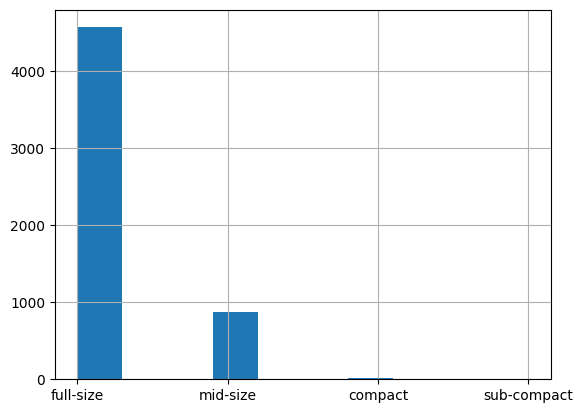

In [36]:
x['size'].hist()

Данный признак является категориальным. Следовательно, понадобится классификатор для заполения пропусков в нем.

In [37]:
data = x.copy()
 
test_data = data[data['size'].isnull()]
data.dropna(inplace=True)
 
y_train = data['size']
X_train = data.drop(['size', 'drive'], axis=1)
X_test = test_data.drop(['size','drive'], axis=1)

In [38]:
X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test, y_train)

In [39]:
model = LogisticRegression()
model.fit(X_train_new, y_train)
 
y_pred = model.predict(X_test_new)
y_pred

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array(['full-size', 'full-size', 'full-size', ..., 'full-size',
       'full-size', 'full-size'], dtype=object)

In [40]:
for i, ni in enumerate(test_data.index[:len(x)]):
             x['size'].loc[ni] = y_pred[i]

/var/folders/71/mrtyv_5x63jbx4zk2kls4n3m0000gn/T/ipykernel_24096/2553570009.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['size'].loc[ni] = y_pred[i]


In [41]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          7017 non-null   int64  
 1   condition     7017 non-null   int64  
 2   cylinders     7017 non-null   int64  
 3   odometer      7017 non-null   int64  
 4   title_status  7017 non-null   object 
 5   transmission  7017 non-null   object 
 6   drive         6626 non-null   object 
 7   size          7017 non-null   object 
 8   lat           7017 non-null   float64
 9   long          7017 non-null   float64
 10  weather       7017 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 603.1+ KB


# Пребодработка: работа с выбросами

Посмотрим, как обработка выбросов влияет на качество модели регрессии. В качестве метрики воспользуемся MAE.

Для начала сформируем baseline-модель. Проведём следующую предобработку: для простоты уберём категориальные столбцы из данных и затем удалим строки с пропусками.

In [42]:
data = pd.read_excel('data_ford_price.xlsx') 

In [43]:
data = data[['price', 'year', 'cylinders', 'odometer' ,'lat', 'long','weather']]
data.dropna(inplace = True)

In [44]:
y = data['price']
x = data.drop(columns='price')
x.head()

,year,cylinders,odometer,lat,long,weather
0,2016,6,43500,36.471500,-82.483400,59.0
1,2009,8,98131,40.468826,-74.281734,52.0
2,2002,8,201803,42.477134,-82.949564,45.0
3,2000,8,170305,40.764373,-82.349503,49.0
5,2003,8,167662,45.518031,-122.578752,50.0


In [45]:
from sklearn.metrics import mean_absolute_error

In [46]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)

model = LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)


MAE: 4682.957


Настало время обработки выбросов.

1
Первый алгоритм, который мы применим, — Isolation Forest, или iForest. Это алгоритм обнаружения аномалий на основе дерева.

Данный метод стремится изолировать аномалии, которые немногочисленны и различаются по пространству признаков.

Библиотека scikit-learn предоставляет реализацию Isolation Forest в классе IsolationForest.

Одним из основных гиперпараметров модели является contamination («загрязнение»), который используется для оценки количества выбросов в наборе данных. Его значение находится в диапазоне от 0.0 до 0.5 и по умолчанию равно 0.1.

In [47]:
from  sklearn.ensemble import IsolationForest
 
# ищем выбросы в обучающей выборке
iso = IsolationForest(contamination=0.1)
y_predicted = iso.fit_predict(X_train)
 
# выберем все строки, которые не являются выбросами
mask = y_predicted != -1
X_train, y_train = X_train[mask], y_train[mask]
 
print(X_train.shape, y_train.shape)
 
model = LinearRegression()
model.fit(X_train, y_train)
 
y_predicted = model.predict(X_test)
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


(4307, 6) (4307,)
MAE: 4449.712


Следующий метод — Local Outlier Factor, или LOF. Это метод, который пытается использовать идею ближайших соседей для обнаружения выбросов.

Каждому примеру присваивается оценка того, насколько он изолирован от его локальных соседей. Примеры, которые наиболее отдалены от соседей, скорее всего, будут являться выбросами.

Библиотека scikit-learn обеспечивает реализацию этого подхода в классе LocalOutlierFactor.

In [48]:
from sklearn.neighbors import LocalOutlierFactor
 
lof = LocalOutlierFactor()
y_predicted = lof.fit_predict(X_train)

mask = y_predicted != -1
X_train, y_train = X_train[mask], y_train[mask]
 
print(X_train.shape, y_train.shape)
 
model = LinearRegression()
model.fit(X_train, y_train)
 
y_predicted = model.predict(X_test)
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

(3974, 6) (3974,)
MAE: 4436.501


Напоследок рассмотрим Minimum Covariance Determinant, или MCD.

Если входные переменные имеют гауссово распределение, то для обнаружения выбросов можно использовать простые статистические методы.

Например, если набор данных имеет две входные переменные и обе они являются гауссовыми, то пространство признаков образует многомерную гауссовскую зависимость, и знание этого распределения можно использовать для определения значений, далёких от распределения.

Этот подход можно обобщить, определив гиперсферу (эллипсоид), которая покрывает нормальные данные, а данные, выходящие за пределы этой формы, считаются выбросами. Эффективная реализация этого метода для многомерных данных известна как детерминант минимальной ковариации (MCD).

Библиотека scikit-learn предоставляет доступ к этому методу через класс EllipticEnvelope.



In [49]:
from sklearn.covariance import EllipticEnvelope
 
ee = EllipticEnvelope(contamination=0.01)
y_predicted = ee.fit_predict(X_train)

mask = y_predicted != -1
X_train, y_train = X_train[mask], y_train[mask]
 
print(X_train.shape, y_train.shape)
 
model = LinearRegression()
model.fit(X_train, y_train)
 
y_predicted = model.predict(X_test)
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

(3934, 6) (3934,)
MAE: 4446.897
